In [60]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import openml
import seaborn as sns

from sklearn.decomposition import KernelPCA
from sklearn.metrics import r2_score

# state-of-the-art ensemble regressors
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor

In [61]:
def get_point_in_semantic_space(predictor, X, y_true) :
    
    y_pred = predictor.predict(X)

    return np.subtract(y_true, y_pred)

def get_points_in_semantic_space_from_predictors(predictors, X, y_true) :
    
    semantic_points = np.zeros((len(predictors), y_true.shape[0]))
    
    for i, predictor in enumerate(predictors) :
        semantic_points[i,:] = get_point_in_semantic_space(predictor, X, y_true)
        
    return semantic_points

In [62]:
# set a nice style for the plots (hopefully)
sns.set_style()

# hard-coded values
random_seed = 42
n_estimators = 100

# load OpenML-CTR23, a regression benchmark suite with 35 benchmarks
suite = openml.study.get_suite(353)
print(suite)

# let's focus on a specific task, for the moment
# 361249 is 'white_wine', 4898 samples and 12 features
task_ids = [361249]

OpenML Benchmark Suite
ID..............: 353
Name............: OpenML-CTR23 - A curated tabular regression benchmarking suite
Status..........: in_preparation
Main Entity Type: task
Study URL.......: https://www.openml.org/s/353
# of Data.......: 35
# of Tasks......: 35
Creator.........: https://www.openml.org/u/30127
Upload Time.....: 2023-05-31 16:39:49


Now working on task #361249...
X: [[ 7.    0.27  0.36 ...  3.    0.45  8.8 ]
 [ 6.3   0.3   0.34 ...  3.3   0.49  9.5 ]
 [ 8.1   0.28  0.4  ...  3.26  0.44 10.1 ]
 ...
 [ 6.5   0.24  0.19 ...  2.99  0.46  9.4 ]
 [ 5.5   0.29  0.3  ...  3.34  0.38 12.8 ]
 [ 6.    0.21  0.38 ...  3.26  0.32 11.8 ]]
y: (4898,)
Column names: ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol']
Creating reference points...
Computing cosine-similarity kPCA...


C:\Users\Alberto\anaconda3\lib\site-packages\openml\tasks\functions.py:372: FutureWarning: Starting from Version 0.15.0 `download_splits` will default to ``False`` instead of ``True`` and be independent from `download_data`. To disable this message until version 0.15 explicitly set `download_splits` to a bool.
  warnings.warn(
C:\Users\Alberto\anaconda3\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(


Text(0, 0.5, 'kPCA dimension 2')

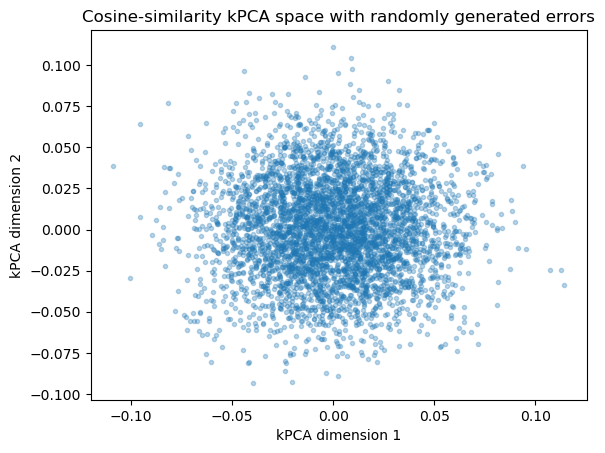

In [63]:
task_id = task_ids[0]

print("Now working on task #%d..." % task_id)

# we also get the indices of the first fold, to use them as a measure of effectiveness
task = openml.tasks.get_task(task_id)
train_indices, test_indices = task.get_train_test_split_indices(repeat=0, fold=0, sample=0)

dataset = task.get_dataset()
X_df, y, categorical_indicator, attribute_names = dataset.get_data(target=dataset.default_target_attribute)
X = X_df.values
print("X:", X)
print("y:", y.shape)
print("Column names:", attribute_names)

# get the split
X_train, X_test = X[train_indices], X[test_indices]
y_train, y_test = y[train_indices], y[test_indices]

print("Creating reference points...")
#reference_points = create_kpca_reference_points(y.shape[0])
rng = np.random.default_rng(seed=random_seed)
reference_points = rng.standard_normal(size=(X_train.shape[0], X_train.shape[0]))

print("Computing cosine-similarity kPCA...")
kpca = KernelPCA(n_components=2, kernel='cosine', random_state=random_seed)
rp_pca = kpca.fit_transform(reference_points)

# let's create a first plot
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(rp_pca[:,0], rp_pca[:,1], marker='.', alpha=0.3)

ax.set_title("Cosine-similarity kPCA space with randomly generated errors")
ax.set_xlabel("kPCA dimension 1")
ax.set_ylabel("kPCA dimension 2")

Now working with Random Forest...


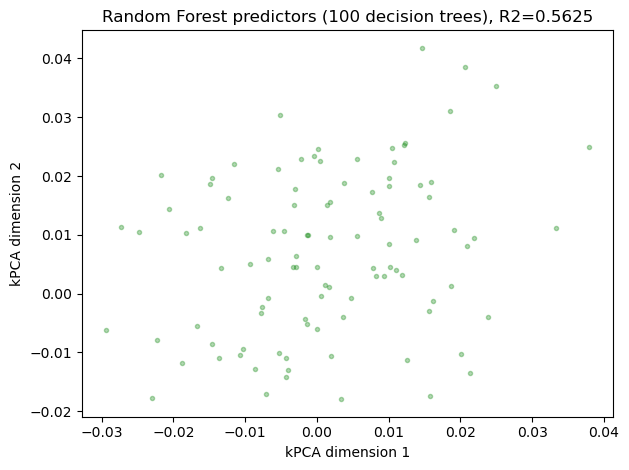

In [66]:
# and now we go more in depth, analyzing how each regressor generates its trees
# (weak predictors) inside the kPCA space we just created
# TODO  we might consider having a train/test split, but does it matter?
#       well, it might matter to have an assessment of performance

# let's start with good ol' Random Forest
print("Now working with Random Forest...")
rf_regressor = RandomForestRegressor(random_state=random_seed)
rf_regressor.fit(X_train, y_train)
y_test_pred = rf_regressor.predict(X_test)
performance = r2_score(y_test, y_test_pred)

# now, we test each tree on the training data, to get the errors with respect to each sample
rf_semantic_points = get_points_in_semantic_space_from_predictors(rf_regressor.estimators_, X_train, y_train)
rf_behavior_points = kpca.transform(rf_semantic_points)

# another plot
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(rf_behavior_points[:,0], rf_behavior_points[:,1], marker='.', alpha=0.3, color='green')

ax.set_title("Random Forest predictors (%d decision trees), R2=%.4f" % (len(rf_regressor.estimators_), performance))
ax.set_xlabel("kPCA dimension 1")
ax.set_ylabel("kPCA dimension 2")

plt.tight_layout()

Now working with Gradient Boosting...


AttributeError: 'LGBMRegressor' object has no attribute 'estimators_'

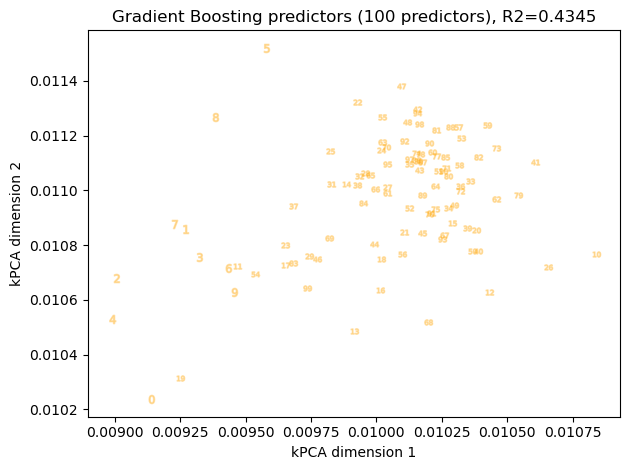

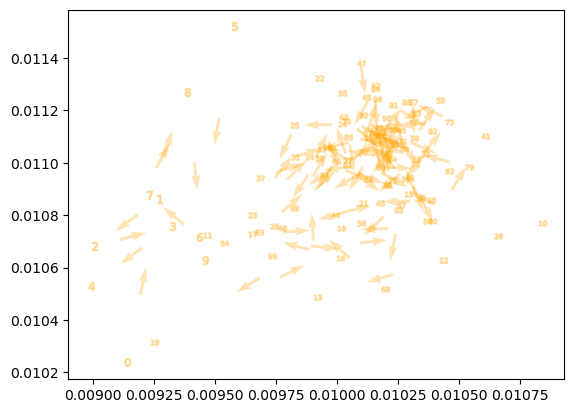

In [67]:
# let's proceed on to Gradient Boosting
print("Now working with Gradient Boosting...")
gb_regressor = GradientBoostingRegressor(random_state=random_seed)
gb_regressor.fit(X_train, y_train)
y_test_pred = gb_regressor.predict(X_test)
performance = r2_score(y_test, y_test_pred)

gb_semantic_points = get_points_in_semantic_space_from_predictors(
    [e[0] for e in gb_regressor.estimators_], X_train, y_train
    )
gb_behavior_points = kpca.transform(gb_semantic_points)

# and another plot
fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(0, gb_behavior_points.shape[0]) :
    ax.scatter(gb_behavior_points[i,0], gb_behavior_points[i,1], marker="$%d$" % i, alpha=0.3, color='orange')

ax.set_title("Gradient Boosting predictors (%d predictors), R2=%.4f" % (len(gb_regressor.estimators_), performance))
ax.set_xlabel("kPCA dimension 1")
ax.set_ylabel("kPCA dimension 2")

plt.tight_layout()

# and another plot!
fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(0, gb_behavior_points.shape[0]) :
    ax.scatter(gb_behavior_points[i,0], gb_behavior_points[i,1], marker="$%d$" % i, alpha=0.3, color='orange')

# all this block of code is just to plot some arrows
x = gb_behavior_points[:,0]
y = gb_behavior_points[:,1]
u = np.diff(x)
v = np.diff(y)
pos_x = x[:-1] + u/2
pos_y = y[:-1] + v/2
norm = np.sqrt(u**2+v**2)
ax.quiver(pos_x, pos_y, u/norm, v/norm, angles="xy", zorder=5, pivot="mid", color='orange', alpha=0.3)

ax.set_title("Gradient Boosting predictors (%d predictors)" % len(regressor.estimators_))
ax.set_xlabel("kPCA dimension 1")
ax.set_ylabel("kPCA dimension 2")

plt.tight_layout()

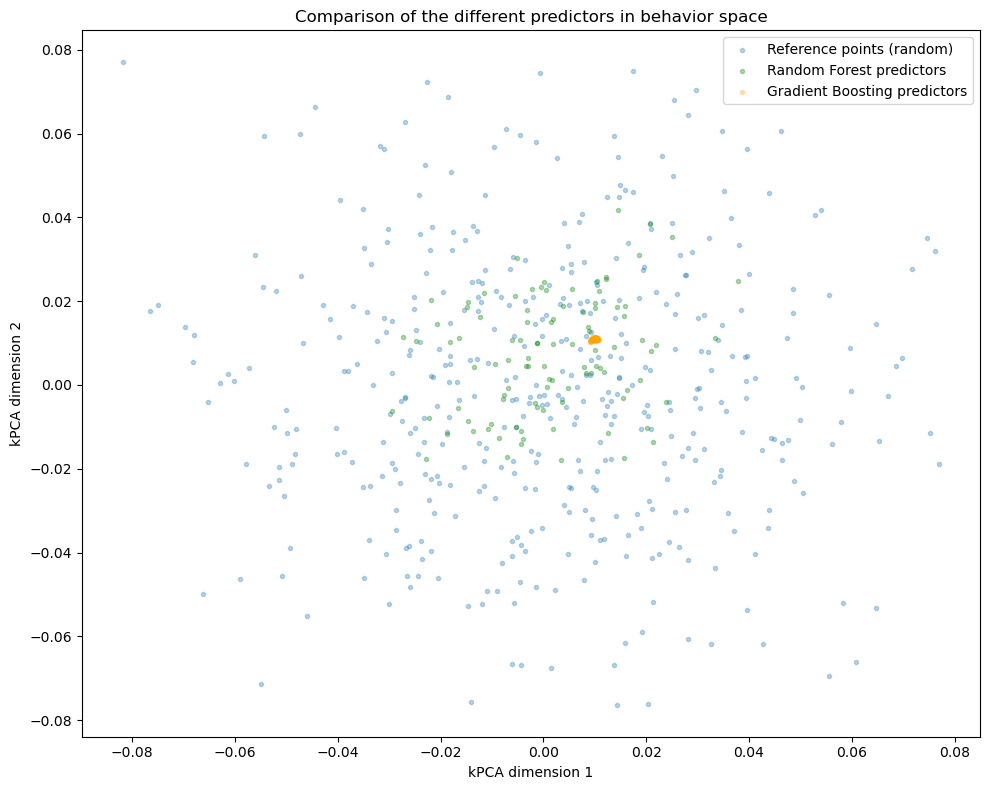

In [68]:
# and another plot! This time, let's put all points together and see if it is still readable
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

# this [0::10,0] means 'starting from 0, go to '' (end), taking one point every 10'
ax.scatter(rp_pca[0::10,0], rp_pca[0::10,1], marker='.', alpha=0.3, label="Reference points (random)")
ax.scatter(rf_behavior_points[:,0], rf_behavior_points[:,1], marker='.', alpha=0.3, color='green', label="Random Forest predictors")
ax.scatter(gb_behavior_points[:,0], gb_behavior_points[:,1], marker='.', alpha=0.3, color='orange', label="Gradient Boosting predictors")

ax.set_title("Comparison of the different predictors in behavior space")
ax.set_xlabel("kPCA dimension 1")
ax.set_ylabel("kPCA dimension 2")
ax.legend(loc='best')

plt.tight_layout()

Text(0.5, 1.0, 'Convex hulls of the predictors in behavior space (even more zoomed in)')

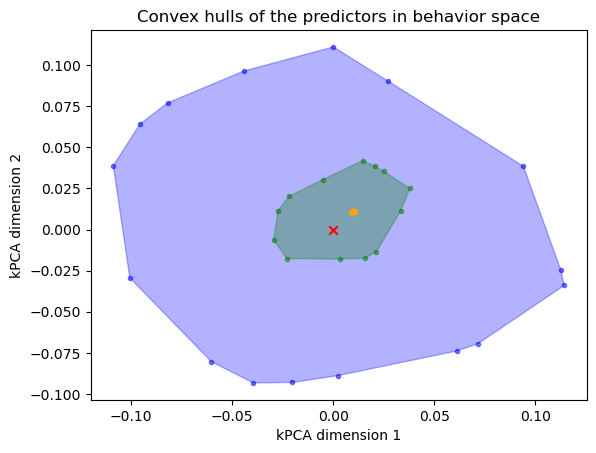

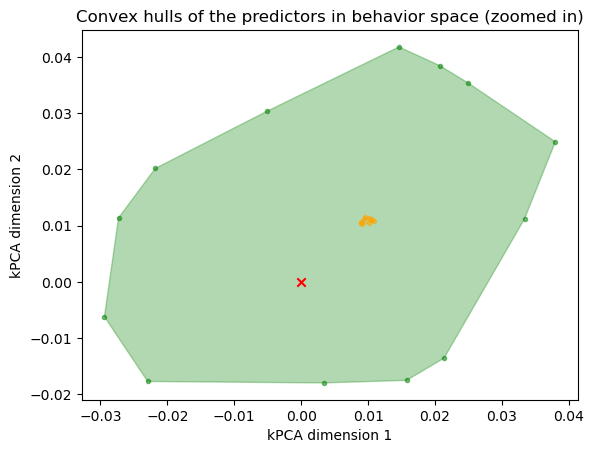

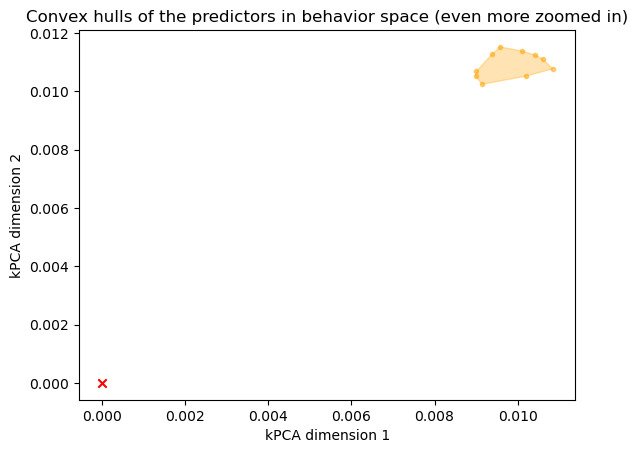

In [69]:
# another plot, this time we just plot the convex hull of each set of points
from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon

hull_reference = ConvexHull(rp_pca)
hull_random_forest = ConvexHull(rf_behavior_points)
hull_gradient_boosting = ConvexHull(gb_behavior_points)

fig = plt.figure()
ax = fig.add_subplot(111)

# obtain all points that are at the vertices of the convex hull
patch_reference = Polygon(rp_pca[hull_reference.vertices,:], facecolor='blue', edgecolor='blue', alpha=0.3)
ax.scatter(rp_pca[hull_reference.vertices,0], rp_pca[hull_reference.vertices,1], marker='.', color='blue', alpha=0.5)
ax.add_patch(patch_reference)

patch_random_forest = Polygon(rf_behavior_points[hull_random_forest.vertices,:], facecolor='green', edgecolor='green', alpha=0.3)
ax.scatter(rf_behavior_points[hull_random_forest.vertices,0], rf_behavior_points[hull_random_forest.vertices,1], marker='.', color='green', alpha=0.5)
ax.add_patch(patch_random_forest)

patch_gradient_boosting = Polygon(gb_behavior_points[hull_gradient_boosting.vertices,:], facecolor='orange', edgecolor='orange', alpha=0.3)
ax.scatter(gb_behavior_points[hull_gradient_boosting.vertices,0], gb_behavior_points[hull_gradient_boosting.vertices,1], marker='.', color='orange', alpha=0.5)
ax.add_patch(patch_gradient_boosting)

# let's add an 'X' for the [0,0] reference
ax.scatter([0.0], [0.0], marker='x', color='red')

ax.set_xlabel("kPCA dimension 1")
ax.set_ylabel("kPCA dimension 2")
ax.set_title("Convex hulls of the predictors in behavior space")

# another one, only with Random Forest and Gradient Boosting (zoomed in)
fig = plt.figure()
ax = fig.add_subplot(111)

# obtain all points that are at the vertices of the convex hull
patch_random_forest = Polygon(rf_behavior_points[hull_random_forest.vertices,:], facecolor='green', edgecolor='green', alpha=0.3)
ax.scatter(rf_behavior_points[hull_random_forest.vertices,0], rf_behavior_points[hull_random_forest.vertices,1], marker='.', color='green', alpha=0.5)
ax.add_patch(patch_random_forest)

patch_gradient_boosting = Polygon(gb_behavior_points[hull_gradient_boosting.vertices,:], facecolor='orange', edgecolor='orange', alpha=0.3)
ax.scatter(gb_behavior_points[hull_gradient_boosting.vertices,0], gb_behavior_points[hull_gradient_boosting.vertices,1], marker='.', color='orange', alpha=0.5)
ax.add_patch(patch_gradient_boosting)

# let's add an 'X' for the [0,0] reference
ax.scatter([0.0], [0.0], marker='x', color='red')

ax.set_xlabel("kPCA dimension 1")
ax.set_ylabel("kPCA dimension 2")
ax.set_title("Convex hulls of the predictors in behavior space (zoomed in)")

# another one, only with Gradient Boosting
fig = plt.figure()
ax = fig.add_subplot(111)

patch_gradient_boosting = Polygon(gb_behavior_points[hull_gradient_boosting.vertices,:], facecolor='orange', edgecolor='orange', alpha=0.3)
ax.scatter(gb_behavior_points[hull_gradient_boosting.vertices,0], gb_behavior_points[hull_gradient_boosting.vertices,1], marker='.', color='orange', alpha=0.5)
ax.add_patch(patch_gradient_boosting)

# let's add an 'X' for the [0,0] reference
ax.scatter([0.0], [0.0], marker='x', color='red')

ax.set_xlabel("kPCA dimension 1")
ax.set_ylabel("kPCA dimension 2")
ax.set_title("Convex hulls of the predictors in behavior space (even more zoomed in)")

In [70]:
regressor = XGBRegressor(random_state=random_seed)
regressor.fit(X_train, y_train)

y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

performance = r2_score(y_test, y_test_pred)
print("Peformance of XGBoost: %.4f" % performance)

Peformance of XGBoost: 0.5434


In [71]:
# to simplify our life, XGBoost does not have a simple '.estimators_' access to the single trees; we need to perform the
# predictions by iterating over its trees, while transforming the training data to another priorietary data structure
from xgboost import DMatrix
xb_trees = [tree for tree in regressor.get_booster()]
xb_semantic_points = np.zeros((len(xb_trees), X_train.shape[0]))
for i, tree in enumerate(xb_trees) :
    xb_semantic_points[i] = tree.predict(DMatrix(X_train))
xb_behavior_points = kpca.transform(xb_semantic_points)

Text(0.5, 1.0, 'Convex hulls of the predictors in behavior space')

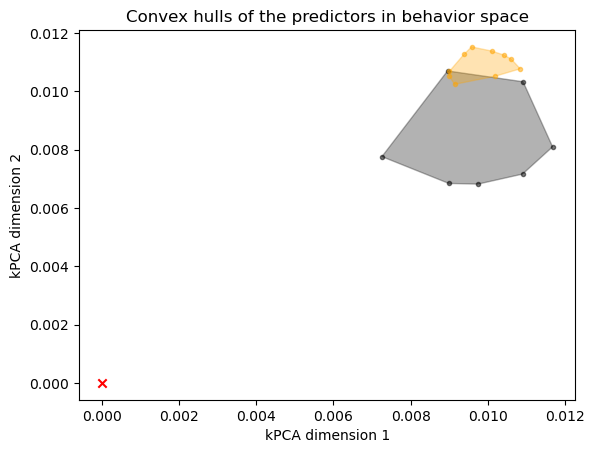

In [59]:
# now, let's plot a figure with XGBoost predictors in behavior space
hull_xgboost = ConvexHull(xb_behavior_points)

fig = plt.figure()
ax = fig.add_subplot(111)

patch_random_forest = Polygon(rf_behavior_points[hull_random_forest.vertices,:], facecolor='green', edgecolor='green', alpha=0.3)
#ax.scatter(rf_behavior_points[hull_random_forest.vertices,0], rf_behavior_points[hull_random_forest.vertices,1], marker='.', color='green', alpha=0.5)
#ax.add_patch(patch_random_forest)

patch_xgboost = Polygon(xb_behavior_points[hull_xgboost.vertices,:], facecolor='black', edgecolor='black', alpha=0.3)
ax.scatter(xb_behavior_points[hull_xgboost.vertices,0], xb_behavior_points[hull_xgboost.vertices,1], marker='.', color='black', alpha=0.5)
ax.add_patch(patch_xgboost)

patch_gradient_boosting = Polygon(gb_behavior_points[hull_gradient_boosting.vertices,:], facecolor='orange', edgecolor='orange', alpha=0.3)
ax.scatter(gb_behavior_points[hull_gradient_boosting.vertices,0], gb_behavior_points[hull_gradient_boosting.vertices,1], marker='.', color='orange', alpha=0.5)
ax.add_patch(patch_gradient_boosting)

# let's add an 'X' for the [0,0] reference
ax.scatter([0.0], [0.0], marker='x', color='red')

ax.set_xlabel("kPCA dimension 1")
ax.set_ylabel("kPCA dimension 2")
ax.set_title("Convex hulls of the predictors in behavior space")

In [72]:
# we do the same, but for lightgbm
regressor = LGBMRegressor(random_state=random_seed)
regressor.fit(X_train, y_train)

y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

performance = r2_score(y_test, y_test_pred)
print("Performance of LightGBM: %.4f" % performance)

Performance of LightGBM: 0.5379


In [73]:
# now, OF COURSE LightGBM has AN ENTIRELY DIFFERENT WAY of accessing the single estimators
# luckily, we can get each tree's prediction using .predict() with pred_leaf=True
lgb_semantic_points = regressor.predict(X_train, pred_leaf=True).T # trasposed, because we need the trees as rows and samples as columns
print("Shape of lgb_semantic_points:", lgb_semantic_points.shape)
print("Shape of rf_semantic_points:", rf_semantic_points.shape)


Shape of lgb_semantic_points: (100, 4408)
Shape of rf_semantic_points: (100, 4408)


Text(0.5, 1.0, 'Convex hulls of the predictors in behavior space')

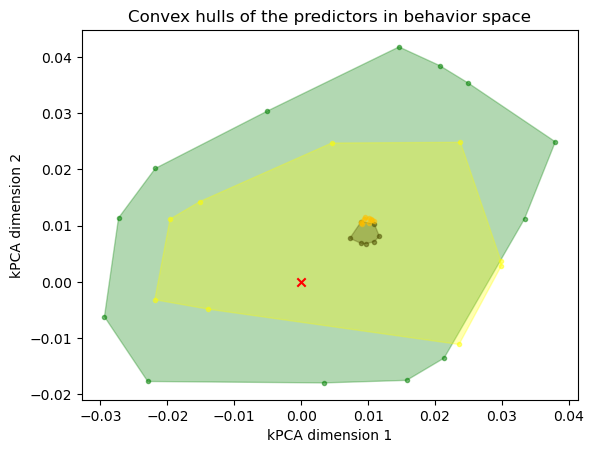

In [74]:
# shapes are coherent, so now we can now map from semantic space to behavior space and replot our stuff
lgb_behavior_points = kpca.transform(lgb_semantic_points)
hull_lgb = ConvexHull(lgb_behavior_points)

fig = plt.figure()
ax = fig.add_subplot(111)

patch_random_forest = Polygon(rf_behavior_points[hull_random_forest.vertices,:], facecolor='green', edgecolor='green', alpha=0.3)
ax.scatter(rf_behavior_points[hull_random_forest.vertices,0], rf_behavior_points[hull_random_forest.vertices,1], marker='.', color='green', alpha=0.5)
ax.add_patch(patch_random_forest)

patch_xgboost = Polygon(xb_behavior_points[hull_xgboost.vertices,:], facecolor='black', edgecolor='black', alpha=0.3)
ax.scatter(xb_behavior_points[hull_xgboost.vertices,0], xb_behavior_points[hull_xgboost.vertices,1], marker='.', color='black', alpha=0.5)
ax.add_patch(patch_xgboost)

patch_gradient_boosting = Polygon(gb_behavior_points[hull_gradient_boosting.vertices,:], facecolor='orange', edgecolor='orange', alpha=0.3)
ax.scatter(gb_behavior_points[hull_gradient_boosting.vertices,0], gb_behavior_points[hull_gradient_boosting.vertices,1], marker='.', color='orange', alpha=0.5)
ax.add_patch(patch_gradient_boosting)

patch_lgb = Polygon(lgb_behavior_points[hull_lgb.vertices,:], facecolor='yellow', edgecolor='yellow', alpha=0.3)
ax.scatter(lgb_behavior_points[hull_lgb.vertices,0], lgb_behavior_points[hull_lgb.vertices,1], marker='.', color='yellow', alpha=0.5)
ax.add_patch(patch_lgb)

# let's add an 'X' for the [0,0] reference
ax.scatter([0.0], [0.0], marker='x', color='red')

ax.set_xlabel("kPCA dimension 1")
ax.set_ylabel("kPCA dimension 2")
ax.set_title("Convex hulls of the predictors in behavior space")

In [85]:
# let's test something: what happens if we take Random Forest, but only average predictions of the trees on the vertices
# of the convex hull in the behavior space?

# a first check: let's see what happens if we just average predictions of the single predictors
y_test_pred_global = np.zeros(y_test.shape)
y_test_pred_estimator = np.zeros((len(rf_regressor.estimators_), y_test.shape[0]))

# iterate over all predictors and get predictions
for i, tree in enumerate(rf_regressor.estimators_) :
    y_test_pred_estimator[i,:] = tree.predict(X_test)

# average predictions
for i in range(0, y_test_pred_global.shape[0]) :
    y_test_pred_global[i] = np.mean(y_test_pred_estimator[:,i])
    
# compute performance
performance_all = r2_score(y_test, y_test_pred_global)
print("Global performance of all predictors: %.4f" % performance_all) # this is good, it's the same performance as the Random Forest, as expected

# compare with performance of predictors on the vertices of the convex hull; luckily they are easy to find, because
# the indexes of the behavior points representing the vertices of the convex hull are also the indexes of the predictors
y_test_pred_selected = np.zeros(y_test.shape)
y_test_pred_estimator_selected = np.zeros((len(hull_random_forest.vertices), y_test.shape[0]))
selected_estimators = [tree for i, tree in enumerate(rf_regressor.estimators_) if i in hull_random_forest.vertices]

for i, tree in enumerate(selected_estimators) :
    y_test_pred_estimator_selected[i] = tree.predict(X_test)
    
# average predictions
for i in range(0, y_test_pred_selected.shape[0]) :
    y_test_pred_selected[i] = np.mean(y_test_pred_estimator_selected[:,i])

performance_selected = r2_score(y_test, y_test_pred_selected)
print("Performance of %d trees on the vertices of the convex hull in behavior space: %.4f" % (len(selected_estimators), performance_selected))

# for comparison, performance of a single decision tree
from sklearn.tree import DecisionTreeRegressor
dt_regressor = DecisionTreeRegressor(random_state=random_seed)
dt_regressor.fit(X_train, y_train)
y_test_pred_dt = dt_regressor.predict(X_test)
performance_dt = r2_score(y_test, y_test_pred_dt)
print("Performance of a single decision tree, as comparision: %.4f" % performance_dt)

Global performance of all predictors: 0.5625
Performance of 13 trees on the vertices of the convex hull in behavior space: 0.5198
Performance of a single decision tree, as comparision: 0.0926
